In [1]:
import numpy as np
from agentflow.numpy.models import Logs

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

Populating the interactive namespace from numpy and matplotlib


In [3]:
N = 32
K = 64
C = 8

In [4]:
mu = np.random.randn(C,K)
sigma = np.random.randn(C,K,K)**2 + 1e-3
eps = np.random.randn(N,K)
y = np.random.choice(C,size=N)
X = (sigma[y]*eps[:,None,:]).sum(axis=-1)
Z = np.random.randn(C,K)
X = X[:,None,:]*Z[None,:,:]
w = np.random.randn(K)

In [5]:
X.shape, y.shape, w.shape

((32, 8, 64), (32,), (64,))

In [6]:
def softmax(X,w):
    exp = np.exp(-np.dot(X,w))
    return exp/exp.sum(axis=-1,keepdims=True)

def logsumexp(h,axis=-1):
    h_max = h.max(axis=axis,keepdims=True)
    return h_max + np.log(np.exp(h-h_max).sum(axis=axis,keepdims=True))

def logsoftmax(X,w):
    h = -np.dot(X,w)
    return h - logsumexp(h)

def nll(X,w,y):
    return -np.take_along_axis(logsoftmax(X,w),y[:,None],axis=1).ravel()

def nll_check(X,w,y):
    p = softmax(X,w)
    y = np.arange(C)[None]==y[:,None]
    return -(y*np.log(p)).sum(axis=1)

def onehot(y,depth):
    return (y[:,None]==np.arange(depth)[None]).astype(float)

np.abs(nll(X,w,y) - nll_check(X,w,y)).max()

2.842170943040401e-14

In [7]:
softmax(X,w).shape, X.shape

((32, 8), (32, 8, 64))

In [31]:
def grad_p(X,w):
    p = softmax(X,w)[:,:,None]
    pTx = (p*X).sum(axis=1,keepdims=True)
    return p*(pTx - X)

def grad(X,w,y):
    p = softmax(X,w)
    y = onehot(y,p.shape[1])
    return (X*(y-p)[:,:,None]).sum(axis=1)

def hessian(X,w):
    p = softmax(X,w)
    Xp = X*p[:,:,None]
    Xpsum = Xp.sum(axis=1)
    Xpsum2 = Xpsum[:,:,None]*Xpsum[:,None,:]
    XXp = (Xp[:,:,:,None]*X[:,:,None,:]).sum(axis=1)
    H = XXp - Xpsum2
    return H

def gradient_checker(func,g_func,X,w,y=None):
    eps = 1e-8
    errs = []
    for i in range(len(w)):
        dw = np.zeros_like(w)
        dw[i] = eps
        if y is None:
            kwargs = {}
        else:
            kwargs = {'y':y}
        f_left = func(X,w-dw,**kwargs)
        f_right = func(X,w+dw,**kwargs)
        dfdwi = (f_right-f_left)/(2*eps)
        g = g_func(X,w,**kwargs)[:,i]
        err = np.abs(g-dfdwi).max()
        errs.append(err)
    max_abs_err = max(errs)
    if max_abs_err >= 1e-1:
        for i,err in enumerate(errs):
            print(i,err)
        raise ValueError('max_abs_err=%0.10f'%max_abs_err)
    else:
        print('max_abs_err=%0.10f'%max_abs_err)
        
gradient_checker(nll,grad,X,w,y)
gradient_checker(grad,lambda X,w,y: hessian(X,w),X,w,y)

max_abs_err=0.0000077682
max_abs_err=0.0000100754


In [9]:
grad(X,w,y).shape

(32, 64)

In [50]:
class Model(object):

    def learn(self,X,y,w0,T=100,lr=1,**update_kwargs):
        w = w0.copy()
        logs = Logs()
        for t in range(T):
            w = self.update(X,w,y,lr,**update_kwargs)
            loss = nll(X,w,y).mean()
            logs.append('loss',loss)
            logs.append('w',w)
        return logs

    def learn_sgd(self,X,y,w0,T=100,lr=1,batchsize=10,**update_kwargs):
        w = w0.copy()
        logs = Logs()
        idx = np.arange(len(X))
        for t in range(T):
            np.random.shuffle(idx)
            i = idx[:batchsize]
            w = self.update(X[i],w,y[i],lr,**update_kwargs)
            loss = nll(X,w,y).mean()
            logs.append('loss',loss)
            logs.append('w',w)
        return logs

class GradientDescent(Model):
    def update(self,X,w,y,lr,alpha=1):
        v = grad(X,w,y).mean(axis=0) + alpha*w
        return w - lr*v
    
class Newton(Model):
    def update(self,X,w,y,lr,alpha=1):
        g = grad(X,w,y).sum(axis=0)
        g += alpha*w.ravel()
        H = hessian(X,w).sum(axis=0) 
        H += alpha*np.eye(len(g))
        H_inv = np.linalg.inv(H)
        v = np.dot(H_inv,g).reshape(*w.shape)
        return w - lr*v
    
class LearnedUpdate(Model):
    
    def update(self,X,w,y,lr,alpha=1):
        p = softmax(X,w)
        y = onehot(y,depth=p.shape[1])
        dpdw = grad_p(X,w)
        err = y-p
        dpdw = dpdw.reshape(-1,dpdw.shape[-1])
        err = err.ravel()
        g = np.dot(err,dpdw) + alpha*w.ravel()
        H = np.dot(dpdw.T,dpdw) + alpha*np.eye(len(g))
        H_inv = np.linalg.inv(H)
        v = np.dot(H_inv,g).reshape(*w.shape)
        return w - lr*v
    
    

In [46]:
grad_p(X,w).shape

(32, 8, 64)

In [47]:
w0 = np.random.randn(*w.shape)

In [48]:
T = 400

#w0 = np.random.randn(K)

inputs = {
    'X': X,
    'y': y,
    'w0': w0,
    'T': T,
}

logs = {
    'gradient_descent': GradientDescent().learn(
        lr=5e-3,alpha=1,**inputs),
    'newton': Newton().learn(
        lr=2e-3,alpha=1,**inputs),
    'learned_update': LearnedUpdate().learn(
        lr=5e-2,alpha=1,**inputs),
    #'learned_update2': LearnedUpdate2().learn(
    #    lr=1,alpha=1e-3,**inputs),
}

Text(0.5, 1.0, 'log(loss)')

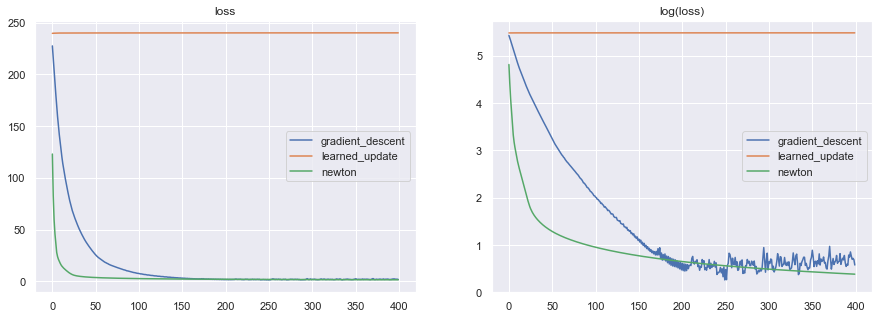

In [49]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
for k in sorted(logs):
    plt.plot(logs[k].stack('loss'),label=k)
plt.legend()
plt.title('loss')

plt.subplot(1,2,2)
for k in sorted(logs):
    plt.plot(np.log(logs[k].stack('loss')),label=k)
plt.legend()
plt.title('log(loss)')

In [24]:
T = 1000

inputs = {
    'X': X,
    'y': y,
    'w0': w0,
    'T': T,
}

logs_sgd = {
    'gradient_descent': GradientDescent().learn_sgd(
        lr=5e-3,alpha=2,**inputs),
    'newton': Newton().learn_sgd(
        lr=2e-3,alpha=2,**inputs),
    #'learned_update': LearnedUpdate().learn_sgd(
    #    lr=1e-1,alpha=1e-3,**inputs),
}

Text(0.5, 1.0, 'log(loss)')

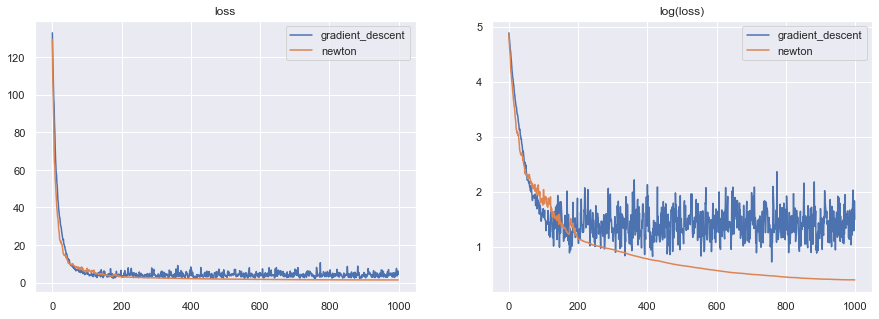

In [25]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
for k in sorted(logs_sgd):
    plt.plot(logs_sgd[k].stack('loss'),label=k)
plt.legend()
plt.title('loss')

plt.subplot(1,2,2)
for k in sorted(logs_sgd):
    plt.plot(np.log(logs_sgd[k].stack('loss')),label=k)
plt.legend()
plt.title('log(loss)')

## Multiple runs

In [249]:
S = 64

sample_logs_sgd = []
for s in range(S):
    T = 1000
    inputs = {
        'X': X,
        'y': y,
        'w0': w0,
        'T': T,
    }
    logs_sgd = {
        'gradient_descent': GradientDescent().learn_sgd(
            lr=1e-2,alpha=2,**inputs),
        'newton': Newton().learn_sgd(
            lr=3e-3,alpha=2,**inputs),
    }
    sample_logs_sgd.append(logs_sgd)

In [250]:
def plot_percentiles(x,label=None):
    mean = x.mean(axis=0)
    p10 = np.percentile(x,5,axis=0)
    p90 = np.percentile(x,95,axis=0)
    [a] = plt.plot(mean,alpha=0.7,label=label)
    plt.fill_between(range(len(p10)),p10,p90,color=a.get_color(),alpha=0.2)

Text(0.5, 1.0, 'log(loss)')

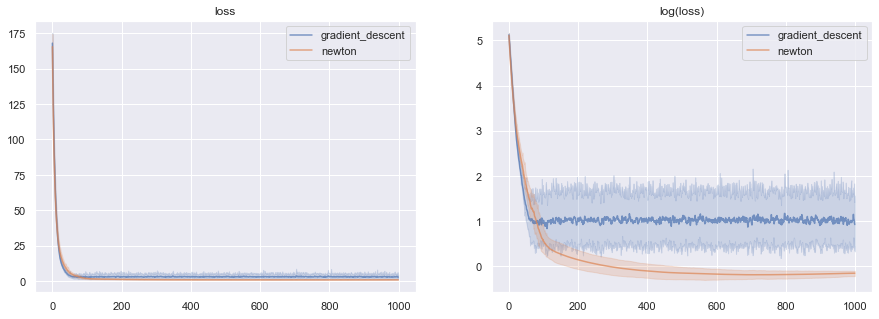

In [251]:
plt.figure(figsize=(15,5))

losses = {
    k: np.stack([l[k].stack('loss') for l in sample_logs_sgd])
    for k in sorted(sample_logs_sgd[0])
}
plt.subplot(1,2,1)
for k in sorted(losses):
    plot_percentiles(losses[k],label=k)
plt.legend()
plt.title('loss')
#plt.ylim(0,2)

plt.subplot(1,2,2)
for k in sorted(logs_sgd):
    plot_percentiles(np.log(losses[k]),label=k)
plt.legend()
plt.title('log(loss)')
#plt.ylim(-0.75,0)
